In [2]:
import torch
import torch.nn as nn

# =================================================================

N = 256 # size of the array of Function F

# =================================================================

# Activation function for fitting
class F(nn.Module):
    """
    Activation function for fitting, works by saving points in a parametrized array
    """
    def __init__(self):
        super(F, self).__init__()
        self.force = nn.Parameter(torch.rand(N), requires_grad=True)
        
    def forward(self, X):
        """
        does an interpolation, in theory takes the input
        int i = v;
        and tries to do
        return F[v] 
        to find the corresponding value to that ´v´
        """

        x, v = X[0], X[1]

        floor_v = v.floor().long()
        ceil_v = (floor_v + 1).clamp(max=N) #adresses the overflow problem
        alpha = v - floor_v.float()

        return [x, (1 - alpha) * self.force[floor_v] + alpha * self.force[ceil_v]]
        



In [3]:
# Example of workings
X = torch.tensor(
    [ [i for i in range(N)] , [i for i in range(N)] ]
    )

force = F()

force.forward(X)

IndexError: index 256 is out of bounds for dimension 0 with size 256

its possible to graph the component of this:

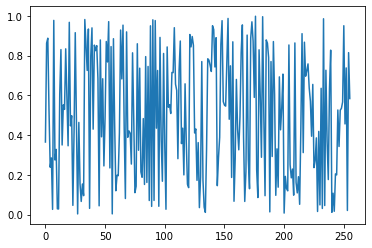

In [4]:
import matplotlib.pyplot as plt

def plot_f(force_parameters):
    # graphing the array inside of this
    force_values = force_parameters.detach().numpy()
    plt.plot(force_values)
    plt.show()

plot_f(force.force)

In [5]:
# lets writte part of a loss function,
# this to smooth the function


def smooth_loss(force_params):
    summatory = 0.0
    for i in range(len(force_params)-1):
        summatory += ( force_params[i+1] - force_params[i] )**2
    return summatory


L2_loss_by_smoothness = smooth_loss(force.force)

# backward propagation
L2_loss_by_smoothness

tensor(49.6811, grad_fn=<AddBackward0>)

In [6]:
L2_loss_by_smoothness.backward()

In [7]:
# ========
# Hyperparameter:
# similar to a learning rate
smooth_rate = 0.03
# ========

with torch.no_grad():
    # force.force = = force.force - smooth_rate * force.force.grad
    force.force -= smooth_rate * force.force.grad 

# also works:
# force.force.data -= force.force.grad


# clear the gradients so they don't accumulate over multiple backward passes
force.force.grad.zero_();

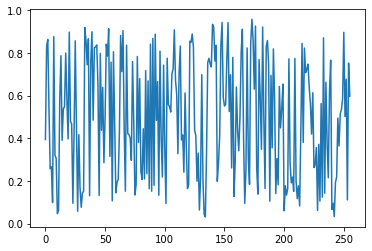

In [8]:
plot_f(force.force)

training with this idea:

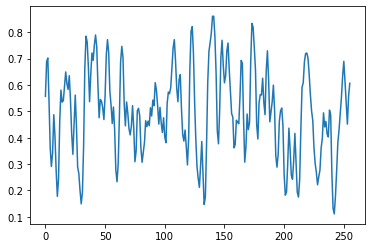

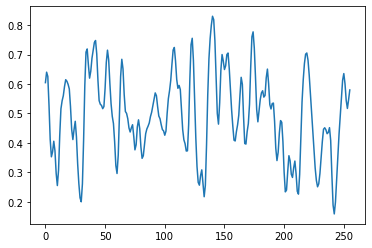

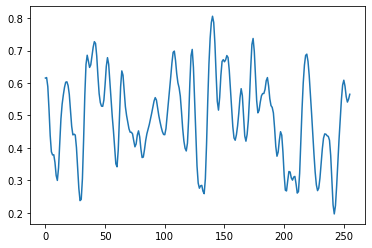

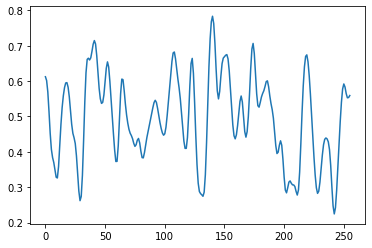

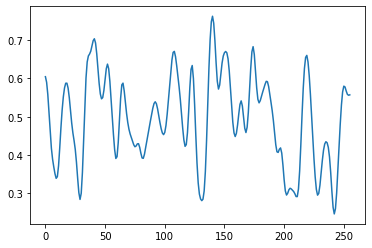

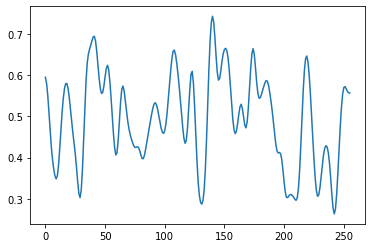

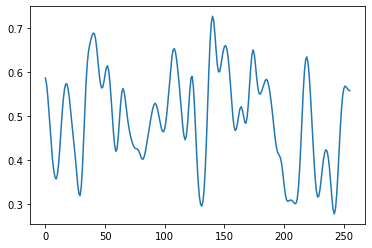

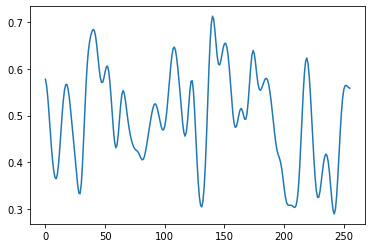

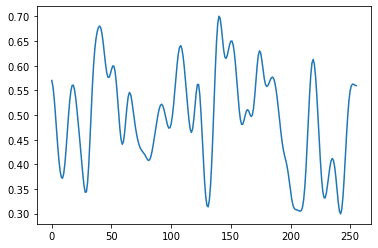

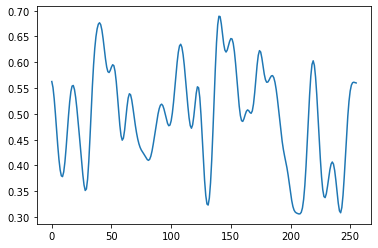

In [9]:

# ========
# Hyperparameter:
# similar to a learning rate
smooth_rate = 0.03
n_epochs = 100
# ========

for epoch in range(n_epochs):
    # here can go a prediction

    # Loss function for smoothness (can be added another to loss)
    L2_loss_by_smoothness = smooth_loss(force.force)

    # backward propagation
    L2_loss_by_smoothness.backward()

    with torch.no_grad():
        force.force -= smooth_rate * force.force.grad 

    force.force.grad.zero_();

    if (epoch+1) % 10 == 0:
        plot_f(force.force)

## constructing a network with this component

In [10]:
class myNet(nn.Module):
    def __init__(self):
        super(myNet, self).__init__()
        self.linear = nn.Linear(2, 2)
        self.force = F()
        
    def forward(self, X):
        X = self.linear(X)

        X = self.force(X)
        return X

In [18]:
model = myNet()
X = torch.tensor([ 1, 2] dtype=torch.float32)
X.shape

torch.Size([2])

In [19]:
X

tensor([1., 2.])

In [20]:
model.forward(X)

[tensor(0.9009, grad_fn=<SelectBackward0>),
 tensor(0.0979, grad_fn=<AddBackward0>)]